In [4]:
import pandas as pd
import glob
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
path = os.path.expanduser('~/illusory-occlusion/online/experiment1/data')

In [ ]:
datapath = glob.glob(path + '/*.csv')

df = [pd.read_csv(doc) for doc in datapath]
big_df = pd.concat(df, ignore_index=True)

## Very general exploratory analysis

In [4]:
len(df)

219

In [5]:
print(big_df.columns)
print(pd.unique(big_df['test_part']))
print(pd.unique(big_df['trialnr']))

Index(['Unnamed: 0', 'means_acc_behval', 'means_acc_behinval',
       'means_acc_frval', 'means_acc_frinval', 'means_rt_behval',
       'means_rt_behinval', 'means_rt_frval', 'means_rt_frinval',
       'diff_acc_validity_behind', 'diff_acc_validity_front',
       'diff_acc_position_valid', 'diff_acc_position_invalid',
       'diff_rt_position_valid', 'diff_rt_position_invalid',
       'performance_index_behval', 'performance_index_behinval',
       'performance_index_frval', 'performance_index_frinval',
       'performance_validity_behind', 'diff_performance_index_front',
       'control_performance', 'acc_behval', 'acc_behinval', 'acc_frval',
       'acc_frinval', 'rt_behval', 'rt_behinval', 'rt_frval', 'rt_frinval',
       'performance_behval', 'performance_behinval', 'performance_frval',
       'performance_frinval', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'success', 'timeout', 'failed_images',
       'failed_audio', 'failed_video', 'rt', 'stimulus', 

In [6]:
big_df['trialnr'].value_counts()

trialnr
0.0      612
1.0      577
2.0      565
3.0      561
4.0      561
        ... 
120.0    552
119.0    552
118.0    552
117.0    552
359.0    552
Name: count, Length: 360, dtype: int64

## Unify csv and correct counterbalance
* 'biological': 1 is bio; 0 is nonbio
* 'behind': 0 front; 1 behind
* 'valid': 1 valid; 0 invalid
* 'cresp': response code ('z' or 'm')
* 'mean_correct': mean of the correct responses of each stimulus
* 'zrt': standarised rt

In [5]:
alldata = pd.DataFrame()
s=0
for f in datapath:
    data = pd.read_csv(f)
    if len(data)==1092: #only keep full datasets
        #data = data[data['test_part'].isin(['stim', 'response'])]
        data = data[data['test_part']=='response']
        s = s+1
        data['subjectnr'] = [s for _ in data['stim']]
        data['biological'] = [int('bio_' in x) for x in data['stim']]
        data['behind'] = ['occluded' if '_behind_' in x else 'not occluded' for x in data['stim']]
        data['valid'] = ['valid' if '_valid' in x else 'invalid' for x in data['stim']]
        c = []
        for x,y in zip(data['biological'],data['task']):
            if '[z] biological' in y:
                c.append('z' if x else 'm')
            else:
                c.append('m' if x else 'z')
        data['cresp'] = c
        data['correct'] = [int(x==y) for x,y in zip(data['response'],data['cresp'])] # accuracy
        data['zrt'] = scipy.stats.zscore(data['rt']) # zscore RT
        alldata = pd.concat((alldata,data))
print(alldata)
with open('responses.csv','w') as out:
    alldata.to_csv(out,index_label='index')

                  trial_type  trial_index  time_elapsed internal_node_id  \
11    html-keyboard-response           11         88755         0.0-11.0   
14    html-keyboard-response           14         91913         0.0-14.0   
17    html-keyboard-response           17         93866         0.0-17.0   
20    html-keyboard-response           20         95660         0.0-20.0   
23    html-keyboard-response           23         97366         0.0-23.0   
...                      ...          ...           ...              ...   
1079  html-keyboard-response         1079        698742       0.0-1079.0   
1082  html-keyboard-response         1082        699553       0.0-1082.0   
1085  html-keyboard-response         1085        700286       0.0-1085.0   
1088  html-keyboard-response         1088        700949       0.0-1088.0   
1091  html-keyboard-response         1091        701799       0.0-1091.0   

     success timeout failed_images failed_audio failed_video      rt  ...  \
11       N

## Exploratory data analysis

In [ ]:
responses_path = f'{path}/responses.csv'

Responses = pd.read_csv(responses_path)

#### Demographic

In [10]:
import json

demographic = []
for f in datapath:
    data = pd.read_csv(f)
    if len(data)==1092: #only keep full datasets
        demographic.append(data[data['trial_type']=='survey-html-form'])
demographic = pd.concat(demographic, ignore_index=True)

ages = []
gender = []
handendess = []
for dem in demographic['response']:
    dem_dict = json.loads(dem)
    if 'age' in dem_dict:
        try:
            ages.append(float(dem_dict['age']))
        except ValueError:
            pass
    if 'gender' in dem_dict:
        gender.append(dem_dict['gender'])
    if 'handedness' in dem_dict:
        handendess.append(dem_dict['handedness'])

print("Ages", "min:", np.min(ages), "max:", np.max(ages), "means ages:", np.mean(ages), "median ages:", np.median(ages), "std ages:", np.std(ages))
print("Genders:", pd.Series(gender).unique(), pd.Series(gender).value_counts())
print("Handendess", pd.Series(handendess).unique(), pd.Series(handendess).value_counts())

Ages min: 17.0 max: 54.0 means ages: 23.942028985507246 median ages: 20.0 std ages: 8.316883575291705
Genders: ['female' 'male' 'nb'] female    112
male       24
nb          2
Name: count, dtype: int64
Handendess ['right' 'left'] right    127
left      11
Name: count, dtype: int64


#### Mean accuracy, SD and rt within subjects

In [7]:
Responses = pd.read_csv(responses_path)

subjectnr = np.unique(Responses['subjectnr'])
subjectnr

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138], dtype=int64)

##### Accuracy

In [83]:
acc_behval = []
acc_behinval = []
acc_frval = []
acc_frinval = []

for s in subjectnr:
    sacc_behval = []
    sacc_behinval = []
    sacc_frval = []
    sacc_frinval = []
    
    for i in range(len(Responses['subjectnr'])):
            if Responses['subjectnr'][i] == s:
                x = Responses['stim'][i]
                if 'behind_valid' in x:
                    sacc_behval.append(Responses['correct'][i])
                elif 'behind_invalid' in x:
                    sacc_behinval.append(Responses['correct'][i])
                elif 'front_valid' in x:
                    sacc_frval.append(Responses['correct'][i])
                elif 'front_invalid' in x:
                    sacc_frinval.append(Responses['correct'][i])

    acc_behval.append(sacc_behval)
    acc_behinval.append(sacc_behinval)
    acc_frval.append(sacc_frval)
    acc_frinval.append(sacc_frinval)


In [ ]:
Avg_raw = pd.DataFrame()
Avg_raw['subjectnr'] = subjectnr
Avg_raw['means_acc_behval'] = np.mean(np.array(acc_behval), axis=1)
Avg_raw['means_acc_behinval'] = np.mean(np.array(acc_behinval), axis=1)
Avg_raw['means_acc_frval'] = np.mean(np.array(acc_frval), axis=1)
Avg_raw['means_acc_frinval'] = np.mean(np.array(acc_frinval), axis=1)
Avg_raw['diff_acc_validity_behind'] = Avg_raw['means_acc_behval'] - Avg_raw['means_acc_behinval']
Avg_raw['diff_acc_validity_front'] = Avg_raw['means_acc_frval'] - Avg_raw['means_acc_frinval']

with open('averages_accuracy.csv','w') as out:
    Avg_raw.to_csv(out,index_label='index')

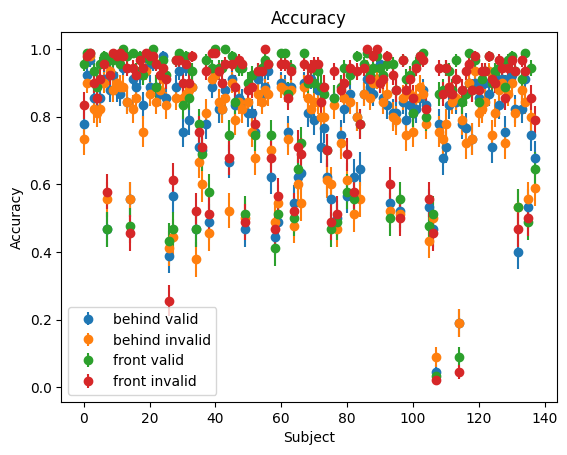

In [ ]:
# sd
Std = pd.DataFrame()
Std['std_acc_behval'] = np.std(np.array(acc_behval), axis=1)
Std['std_acc_behinval'] = np.std(np.array(acc_behinval), axis=1)
Std['std_acc_frval'] = np.std(np.array(acc_frval), axis=1)
Std['std_acc_frinval'] = np.std(np.array(acc_frinval), axis=1)

with open('std_conditions.csv','w') as out:
    Std.to_csv(out,index_label='index')

# se
SE = pd.DataFrame()
SE['se_acc_behval'] = np.std(np.array(acc_behval), axis=1)/np.sqrt(len(acc_behval[0]))
SE['se_acc_behinval'] = np.std(np.array(acc_behinval), axis=1)/np.sqrt(len(acc_behinval[0]))
SE['se_acc_frval'] = np.std(np.array(acc_frval), axis=1)/np.sqrt(len(acc_behinval[0]))
SE['se_acc_frinval'] = np.std(np.array(acc_frinval), axis=1)/np.sqrt(len(acc_behinval[0]))
with open('se_conditions.csv','w') as out:
    SE.to_csv(out,index_label='index')

# Plotting SE
plt.figure()
plt.errorbar(range(len(acc_behval)), Avg_raw['means_acc_behval'], yerr=SE['se_acc_behval'], fmt='o', label='behind valid')
plt.errorbar(range(len(acc_behinval)), Avg_raw['means_acc_behinval'], yerr=SE['se_acc_behinval'], fmt='o', label='behind invalid')
plt.errorbar(range(len(acc_frval)), Avg_raw['means_acc_frval'], yerr=SE['se_acc_frval'], fmt='o', label='front valid')
plt.errorbar(range(len(acc_frinval)), Avg_raw['means_acc_frinval'], yerr=SE['se_acc_frinval'], fmt='o', label='front invalid')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.show()


##### Trim data accuracy

In [ ]:
# only participants where ALL accuracy columns are >= 0.6
Avg_trimmed = pd.DataFrame()
outliers = []
for s in subjectnr:
    if (Avg_raw[['means_acc_behval','means_acc_behinval','means_acc_frval','means_acc_frinval']] >= 0.6).all(axis=1)[s-1]:
        Avg_trimmed['means_acc_behinval'] = Avg_raw['means_acc_behinval'][s-1]
        Avg_trimmed['means_acc_behval'] = Avg_raw['means_acc_behval'][s-1]  
        Avg_trimmed['means_acc_frval'] = Avg_raw['means_acc_frval'][s-1]
        Avg_trimmed['means_acc_frinval'] = Avg_raw['means_acc_frinval'][s-1]
        Avg_trimmed['diff_acc_validity_behind'] = Avg_raw['diff_acc_validity_behind'][s-1]
        Avg_trimmed['diff_acc_validity_front'] = Avg_raw['diff_acc_validity_front'][s-1]
        Avg_trimmed['subjectnr'] = s
    else:
        outliers.append(s)



print(f"Original participants: {len(Avg_raw)}")
print(f"Trimmed participants: {len(Avg_trimmed)}")
print(f"Participants removed: {len(Avg_raw) - len(Avg_trimmed)}")
print(f"Outliers: {outliers}")

Original participants: 138
Trimmed participants: 0
Participants removed: 138
Outliers: [8, 15, 27, 28, 35, 39, 45, 50, 59, 60, 65, 67, 76, 78, 81, 83, 85, 94, 97, 106, 107, 108, 115, 133, 136, 138]


In [ ]:
data = []

conditions = ['behval', 'behinval', 'frval', 'frinval']
#outliers = [108, 115, 61, 78, 85, 79, 80, 126, 114] #outliers (acc and rt)-> 2.5 SD from the mean

for s in subjectnr:
    if s not in outliers:
        for c in conditions:
            avg_dict = {'sub': s}

            if c == 'behval':
                acc_mean = np.mean(np.array(acc_behval)[s-1])
                avg_dict['validity'] = 1
                avg_dict['occlusion'] = 1
                avg_dict['accuracy'] = acc_mean

            elif c == 'behinval':
                acc_mean = np.mean(np.array(acc_behinval)[s-1])
                avg_dict['validity'] = 0
                avg_dict['occlusion'] = 1
                avg_dict['accuracy'] = acc_mean

            elif c == 'frval':
                acc_mean = np.mean(np.array(acc_frval)[s-1])
                avg_dict['validity'] = 1
                avg_dict['occlusion'] = 0
                avg_dict['accuracy'] = acc_mean

            elif c == 'frinval':
                acc_mean = np.mean(np.array(acc_frinval)[s-1])
                avg_dict['validity'] = 0
                avg_dict['occlusion'] = 0
                avg_dict['accuracy'] = acc_mean

            data.append(avg_dict)

Avg = pd.DataFrame(data, index=None)

with open('accuracies_clean.csv','w') as out:
    Avg.to_csv(out,index_label='index')

1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
9
9
10
10
11
11
12
12
13
13
14
14
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
28
29
29
30
30
31
31
32
32
33
33
34
34
35
36
36
37
37
38
38
39
40
40
41
41
42
42
43
43
44
44
45
46
46
47
47
48
48
49
49
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
60
61
61
62
62
63
63
64
64
65
66
66
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
77
77
78
79
79
80
80
81
82
82
83
84
84
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
95
95
96
96
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
107
108
109
109
110
110
111
111
112
112
113
113
114
114
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
134
134
135
135
136
137
137
138


In [121]:
Avg['occlusion'] = Avg['occlusion'].astype(str)

occluded_condition = '1'
# Filter the DataFrame to include only the occluded condition
Avg_occluded = Avg[Avg['occlusion'] == occluded_condition]

In [27]:
Avg['validity'] = Avg['validity'].astype(str) 
Avg_occluded = Avg_occluded.copy()  # Explicit copy
Avg_occluded['validity'] = Avg_occluded['validity'].map({'1': 'valid', '0': 'invalid'})

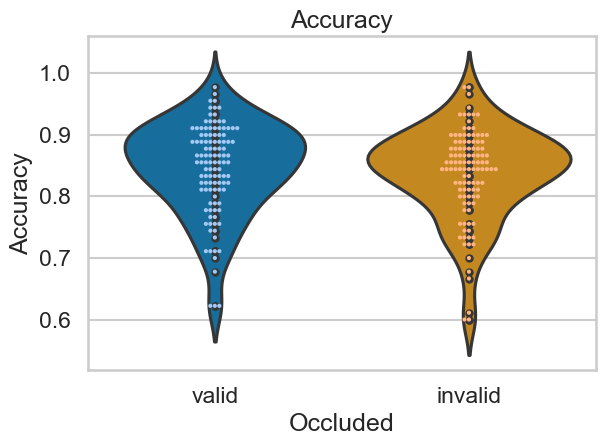

In [122]:
# Plotting without occlusion condition
Avg['occlusion'] = Avg['occlusion'].astype(str)

occluded_condition = '1'
Avg_occluded = Avg[Avg['occlusion'] == occluded_condition]

Avg_occluded = Avg_occluded.copy()
Avg_occluded['validity'] = Avg_occluded['validity'].astype(str) 
Avg_occluded['validity'] = Avg_occluded['validity'].map({'1': 'valid', '0': 'invalid'})


sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots()

violin_palette = {"valid": "#00c6ab", "invalid": "#c600c6"} #invalid = 0, valid=1
swarm_palette = {"valid": "#03ffef", "invalid": "#ff6dff"}

#accuracy
sns.violinplot(x='validity', y='accuracy',data=Avg_occluded, ax=ax,
               inner='point', dodge=True, palette='colorblind')  #Changed colour to palette
sns.swarmplot(x='validity', y='accuracy',data=Avg_occluded, ax=ax, 
              dodge=True, palette='pastel', edgecolor='gray', size=3)  #changed colour to palette

ax.set_title('Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Occluded')


plt.tight_layout()
plt.show()

##### Reaction Times

In [124]:
rt_behval = []
rt_behinval = []
rt_frval = []
rt_frinval = []

for s in subjectnr:
    srt_behval = []
    srt_behinval = []
    srt_frval = []
    srt_frinval = []

    for i in range(len(Responses['subjectnr'])):
            if Responses['subjectnr'][i] == s:
                if Responses['correct'][i] == 1:
                    x = Responses['stim'][i]
                    if 'behind_valid' in x:
                        srt_behval.append(Responses['rt'][i])
                    elif 'behind_invalid' in x:
                        srt_behinval.append(Responses['rt'][i])
                    elif 'front_valid' in x:
                        srt_frval.append(Responses['rt'][i])
                    elif 'front_invalid' in x:
                        srt_frinval.append(Responses['rt'][i])

    rt_behval.append(srt_behval)
    rt_behinval.append(srt_behinval)
    rt_frval.append(srt_frval)
    rt_frinval.append(srt_frinval)
 



In [150]:
outliers = []
for s in subjectnr:
    mean_rt_behval = np.median(rt_behval[s-1])
    mean_rt_behinval = np.median(rt_behinval[s-1])
    mean_rt_frval = np.median(rt_frval[s-1])
    mean_rt_frinval = np.median(rt_frinval[s-1])
    if mean_rt_behval >= 1000:
        print(f"Subject {s} RT behval: {mean_rt_behval}")
        outliers.append(s)
    elif mean_rt_behinval >= 1000:
        print(f"Subject {s} RT behinval: {mean_rt_behinval}")
        outliers.append(s)
    elif mean_rt_frval >= 1000:
        print(f"Subject {s} RT frval: {mean_rt_frval}")
        outliers.append(s)
    elif mean_rt_frinval >= 1000:
        print(f"Subject {s} RT frinval: {mean_rt_frinval}")
        outliers.append(s)
    
            
print(outliers)

Subject 79 RT behval: 1243.0
Subject 115 RT frinval: 1166.0
[79, 115]


In [151]:
data_re = []

conditions = ['behval', 'behinval', 'frval', 'frinval']
#outliers = [108, 115, 61, 78, 85, 79, 80, 126, 114] #outliers (acc and rt) 2.5 std from the median-> >1859 behval, >2526 behinval


for s in subjectnr:
    if s not in outliers:
        for c in conditions:
            rt_dict = {'sub': s}
    
            if c == 'behval':
                rt_median = np.median(rt_behval[s-1])
                rt_std = np.std(rt_behval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_behval[s-1]))
                rt_dict['validity'] = 1
                rt_dict['occlusion'] = 1
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
    
                
            elif c == 'behinval':
                rt_median = np.median(rt_behinval[s-1])
                rt_std = np.std(rt_behinval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_behinval[s-1]))
                rt_dict['validity'] = 0
                rt_dict['occlusion'] = 1
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
    
            elif c == 'frval':
                rt_median = np.median(rt_frval[s-1])
                rt_std = np.std(rt_frval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_frval[s-1]))
                rt_dict['validity'] = 1
                rt_dict['occlusion'] = 0
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
    
            elif c == 'frinval':
                rt_median = np.median(rt_frinval[s-1])
                rt_std = np.std(rt_frinval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_frinval[s-1]))
                rt_dict['validity'] = 0
                rt_dict['occlusion'] = 0
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
            
            data_re.append(rt_dict)


Rt = pd.DataFrame(data_re)

with open('rt_clean.csv','w') as out:
    Rt.to_csv(out,index_label='index')

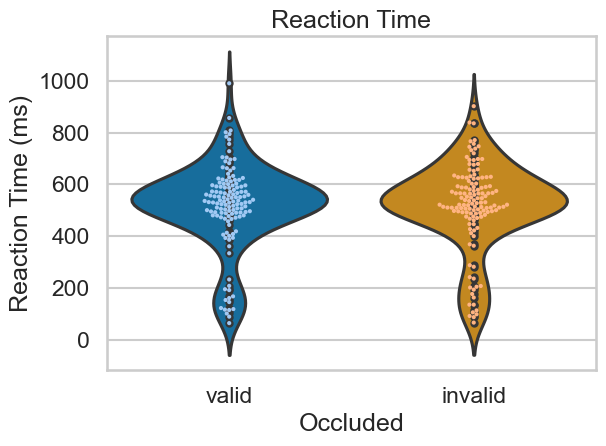

In [152]:
# Plotting without occlusion condition
Rt['occlusion'] = Rt['occlusion'].astype(str)

occluded_condition = '1'
Rt_occluded = Rt[Rt['occlusion'] == occluded_condition]

Rt_occluded = Rt_occluded.copy()  
Rt_occluded['validity'] = Rt_occluded['validity'].astype(str)
Rt_occluded['validity'] = Rt_occluded['validity'].map({'1': 'valid', '0': 'invalid'})

sns.set(style="whitegrid")
sns.set_context("talk")
fig, ax = plt.subplots()

violin_palette = {"valid": "#00c6ab", "invalid": "#c600c6"} #invalid = 0, valid=1
swarm_palette = {"valid": "#03ffef", "invalid": "#ff6dff"}


#reaction times
sns.violinplot(x='validity', y='rt_median', data=Rt_occluded, ax=ax, 
               inner='point', dodge=True, palette='colorblind')  
sns.swarmplot(x='validity', y='rt_median', data=Rt_occluded, ax=ax, 
              dodge=True, palette='pastel', edgecolor='gray', size=3)  

ax.set_title('Reaction Time')
ax.set_ylabel('Reaction Time (ms)')
ax.set_xlabel('Occluded')


plt.tight_layout()
plt.show()